In [1]:
import os
import random
import time
import datetime
import copy
from decimal import Decimal, ROUND_HALF_UP
    
import matplotlib.pyplot as plt
import numpy as np
from netpyne import specs, sim
from neuron import h
import pandas as pd

### SETTINGS ##################

read_folder = 'SWCs'
simplify = False

netParams = specs.NetParams()
netParams.sizeZ = 10
netParams.propVelocity = 55.0    # propagation velocity (um/ms)
netParams.probLengthConst = 600


# Estimated performance for the Octoscope
# https://iopscience.iop.org/article/10.1088/2040-8986/ac5dd5
# 500 Hz over a 95 µm × 477 µm FOV ~~> 500 Hz over a 212 µm x 212 µm FOV
# This is not that amazing for networks. So lets assume that future setups can do better:  
microscope_recording_speed = 500 # Hz
microscope_recording_duration = 80  #ms

impulse_delay = 1 #ms


################################

### Data storage arrays ##########
swc_filenames = []
for file in os.listdir(read_folder):
    if os.path.splitext(file)[-1] == '.swc':
        swc_filenames.append(file)

cells = len(swc_filenames) 

######## POSITIONING ########
X = np.zeros(cells)
Y = np.zeros(cells)
Z = np.zeros(cells)
for ii, swc_fname in enumerate(swc_filenames):
    swc = np.loadtxt(os.path.join(read_folder, swc_fname), max_rows=1)

    X[ii] = swc[2]
    Y[ii] = swc[3]
    Z[ii] = swc[4]
    
Y = Y.max() - Y
    
    
######## CREATING CELLS ########  
cell_labels = []

for ii, swc_fname in enumerate(swc_filenames):

    label = f'trace_{ii:04d}'
    
    cellRule = netParams.importCellParams(
        label=label, 
        conds={'cellType': label},
        fileName=os.path.join(read_folder, swc_fname), 
        cellName=label,
        )
    
    cell_labels.append(label)
    
    # For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.
    netParams.renameCellParamsSec(label, 'soma_0', 'soma')
    
    for secName in cellRule['secs']:
        cellRule['secs'][secName]['geom']['cm'] = 1
        cellRule['secs'][secName]['mechs']['hh'] = {
            'gnabar': 0.12, 
            'gkbar': 0.036, 
            'gl': 0.003, 
            'el': -70,
            }
        
    cellRule_dict = cellRule.todict()
    for jj, secName in enumerate(cellRule['secs']):
          
        parentX = cellRule_dict['secs'][secName]['topol'].get('parentX')
        childX = cellRule_dict['secs'][secName]['topol'].get('childX')
        
        if (parentX == 1.0 or parentX == 0.0) and (childX == 0.0):
            pass
        elif parentX == {} and childX == {}:
            pass #soma
        
        elif parentX is None and childX is None:
            pass 
        elif type(parentX) is float and type(childX) is float:
            # clip to 0-1, round up for 0.5
            cellRule['secs'][secName]['topol']['parentX'] = max(
                min(float(Decimal(parentX).to_integral_value(rounding=ROUND_HALF_UP)), 1.0), 
                0.0)
            
            # clip to 0-1
            cellRule['secs'][secName]['topol']['childX'] = max(
                min(float(round(childX)), 1.0), 
                0.0)

#             print(f"{parentX} --> {cellRule_dict['secs'][secName]['topol']['parentX']}\t" 
#                   f"{childX} --> {cellRule_dict['secs'][secName]['topol']['childX']}")
            
        else:
            raise ValueError('Expected parentX and childX relative positions to be floats between 0-1.'
                             f'\n Instead, got parentX: {parentX} and childX: {childX}')

    netParams.popParams[label] = {'cellType'  : label,
                                  'cellModel' : 'HH3D', 
                                  'numCells'  : 1, 
                                  'xRange'    : [X[ii]-1, X[ii]+1], 
                                  'yRange'    : [Y[ii]-1, Y[ii]+1], 
                                  'zRange'    : [Z[ii]-1, Z[ii]+1],}



In [2]:
swc[0:]

array([  1.   ,   1.   , 806.   , 984.   ,   2.   ,   8.176,  -1.   ])

In [3]:

## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

# netParams.stimSourceParams[f'Probe'] = {'type': 'IClamp', 'del': impulse_delay, 'dur': 300, 'amp': 5}
# # for label in cell_labels:
# netParams.stimTargetParams[f'Probe->{label}'] = {'source': 'Probe', 
#                                              'sec': 'soma',
#                                              'loc': 0.5,
#                                              'conds': {'cellType': cell_labels}}

# Stimulation parameters",
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 20, 'noise': 0.3}
netParams.stimTargetParams['bkg->all'] = {'source': 'bkg', 
                                          'conds': {'cellType': cell_labels}, 
                                          'weight': 0.01, 
                                          'delay': 'max(1, normal(5,2))', 
                                          'synMech': 'exc'}

stim_ii = random.randint(0, cells-1)
print(f'Cell # {stim_ii} is stimulated'),

netParams.stimSourceParams['Probe'] = {'type': 'NetStim', 'rate': 10}
netParams.stimTargetParams['Probe->Cell'] = {'source': 'Probe', 
                                             'conds': {'cellList': [stim_ii]}, 
                                             'weight': 0.5, 'delay': impulse_delay, 'synMech': 'exc'}

# Distance-based connectivity
netParams.connParams['all-E->all'] = {
    'preConds': {'cellType': cell_labels}, 
    'postConds': {'cellType': cell_labels},  #  E -> all (100-1000 um)
    'probability': '1*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '1.80',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'exc'}                     # synaptic mechanism

netParams.connParams['all-I->all'] = {
    'preConds': {'cellType': cell_labels}, 
    'postConds': {'cellType': cell_labels},  #  E -> all (100-1000 um)
    'probability': '0.1*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.01',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'inh'}                     # synaptic mechanism

Cell # 68 is stimulated


In [4]:
cell_labels[stim_ii]

'trace_0068'


Start time:  2022-06-29 00:26:07.422142

Creating network of 205 cell populations on 1 hosts...
  Number of cells on node 0: 205 
  Done; cell creation time = 1.25 s.
Making connections...
  Number of connections on node 0: 17781 
  Number of synaptic contacts on node 0: 19545 
  Done; cell connection time = 3.71 s.
Adding stims...
  Number of stims on node 0: 206 
  Done; cell stims creation time = 0.03 s.
Recording 203 traces of 1 types on node 0

Running simulation using NEURON for 80.0 ms...
  Done; run time = 15.02 s; real-time ratio: 0.01.

Gathering data...
  Done; gather time = 1.68 s.

Analyzing...
  Cells: 205
  Connections: 17986 (87.74 per cell)
  Synaptic contacts: 19751 (96.35 per cell)
  Spikes: 149 (9.09 Hz)
  Simulated time: 0.1 s; 1 workers
  Run time: 15.02 s
Plotting recorded cell traces ... trace


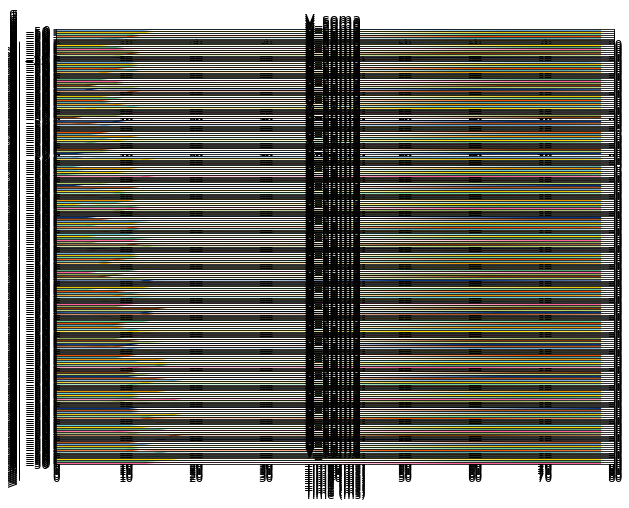

Plotting 2D representation of network cell locations and connections...


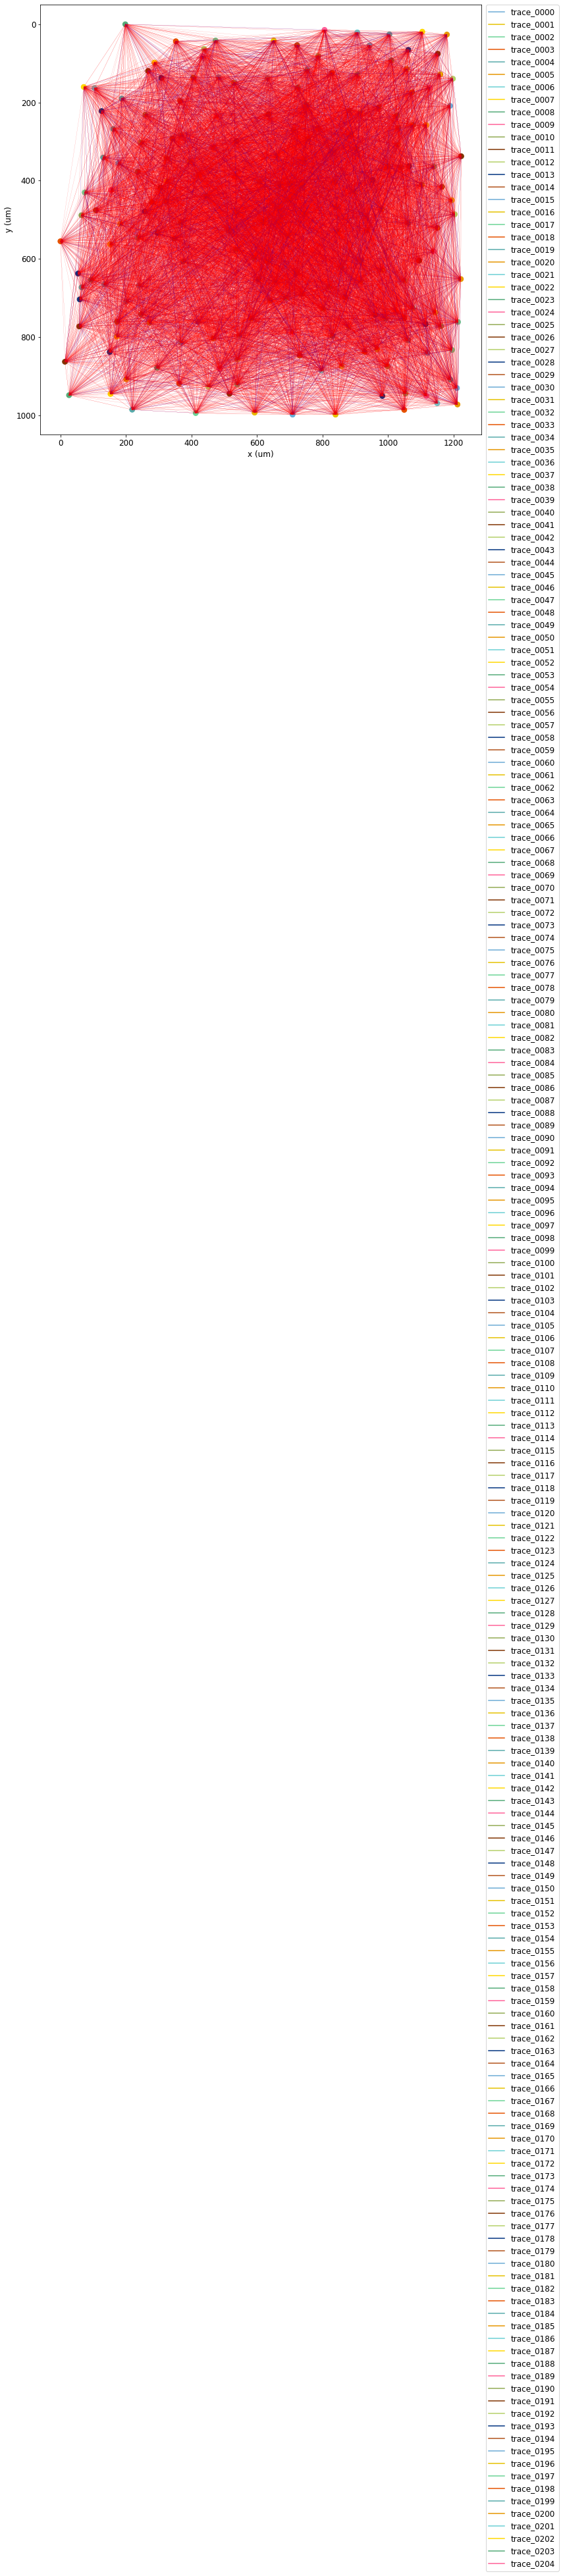

Plotting 3D cell shape ...
Plotting spike stats...


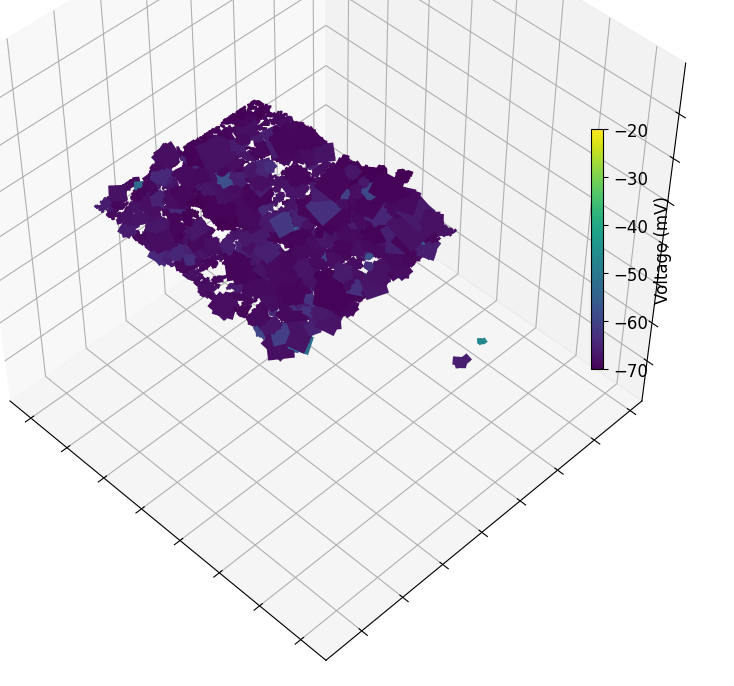

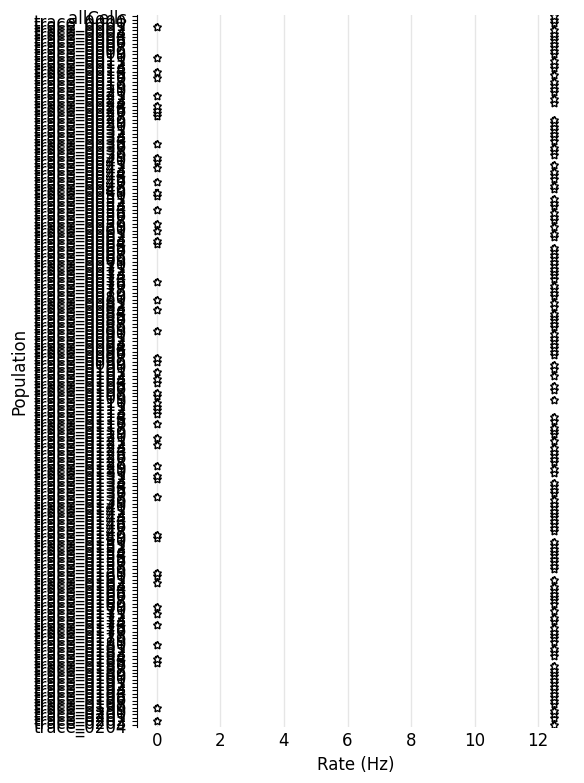

  Done; plotting time = 76.19 s

Total time = 98.03 s


In [5]:
# Simulation options
%matplotlib inline
simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration
simConfig.hParams['celsius'] = 20
simConfig.duration = microscope_recording_duration          # Duration of the simulation, in ms
simConfig.dt = 0.05                 # Internal integration timestep to use
simConfig.verbose = False            # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordCells = range(cells)
simConfig.recordStep = 1/microscope_recording_speed *1000      # Step size in ms to save data (e.g. V traces, LFP, etc)

simConfig.analysis['plotTraces'] = {'oneFigPer' : 'trace' ,
                                    'saveFig': False,
                                   'showFig' : True}  # Plot recorded traces for this list of cells
simConfig.analysis['plot2Dnet'] = {'saveFig': False}                                                # plot 2D cell positions and connections                                         # plot connectivity matrix
simConfig.analysis['plotShape'] = {
                                    'cvar'        : 'voltage', 
                                    'clim'        : [-70, -20], 
                                    'showFig'     : True,
                                    'elev'        : 45, 
                                    'azim'        : -45,
                                    'saveFig': False, 
                                    'showFig' : True
                                }
simConfig.analysis['plotSpikeStats'] = {'stats' : ['rate'],
                                        'showFig'     : True,
                                        'saveFig': False}
# Create network and run simulation
sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)



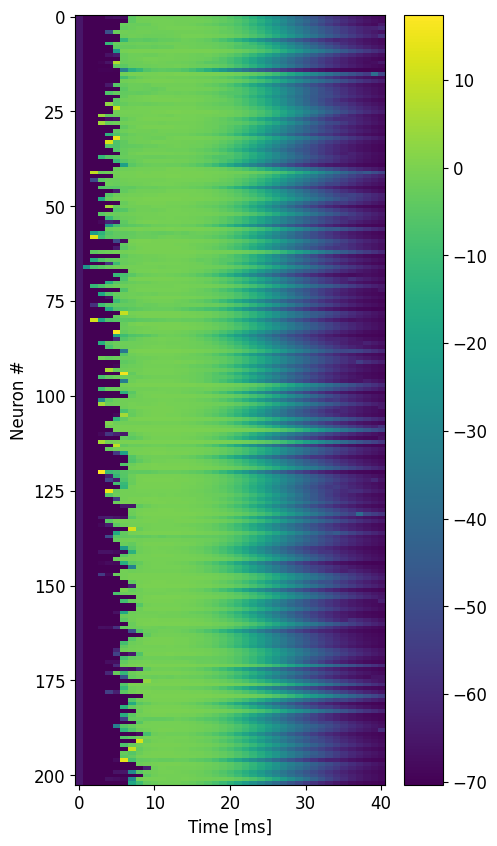

In [6]:

#### Extra plot
data = []
for key, value in sim.simData['V_soma'].items():
    if key[0] is not '_':
        data.append(list(value))
        
data = np.array(data)
fig = plt.figure(figsize=(5, 10))
plt.imshow(data, aspect='auto', interpolation=None)
plt.xlabel('Time [ms]')
plt.ylabel('Neuron #')
plt.colorbar()
plt.show()

In [7]:
print('~~~SETTINGS FOR BlenderNEURON~~~\n')
print('Recording Settings:\n' 
      f'\tRecord Activity  : True\n'
      f'\tRecord from each : Section\n'
      f'\tStart Recording  : 0.00 \n'
      f'\tStop Recording   : {simConfig.duration}\n'
      f'\tRecord           : v \n'
      f'\tSampling Period  : {simConfig.recordStep}\n\n'
      f'\tFrames per\n' 
      f'\t     Millisecond : choose\n\n'
      f'\tSimplification\n'
      f'\t     Tolerance   : 0.10\n\n'
      f'\tAnimate\n'
      f'\t     Brightness  : True\n\n'
      f'\tAnimate Color    : True\n'
      f'\tColor 0          : Hex 000000\n'
      f'\tColor 1          : Hex FFFFFF\n\n'
      f'\tVariable Low     : {np.floor(data.min())}\n'
      f'\tVariable High    : {np.ceil(data.max())}\n'
     )

print('NEURON:\n' 
      f'\tStop Time (ms)   : {simConfig.duration}\n'
      f'\tTemperature (°C) : 20 \n'
     )

print('~~~CHECK SCALE~~~\n')
middle_cell_label = cell_labels[cells//2]
middle_cell_soma_size = netParams.cellParams[middle_cell_label]['secs']['soma']['geom']['diam']
print(f'Soma diameter of middle cell : {middle_cell_soma_size:.2f}\n')

import sys 

sys.path.insert(1, r'C:\Users\twh\PycharmProjects\duet\Synthetic Data')

from blenderneuron import neuronstart


~~~SETTINGS FOR BlenderNEURON~~~

Recording Settings:
	Record Activity  : True
	Record from each : Section
	Start Recording  : 0.00 
	Stop Recording   : 80.0
	Record           : v 
	Sampling Period  : 2.0

	Frames per
	     Millisecond : choose

	Simplification
	     Tolerance   : 0.10

	Animate
	     Brightness  : True

	Animate Color    : True
	Color 0          : Hex 000000
	Color 1          : Hex FFFFFF

	Variable Low     : -71.0
	Variable High    : 18.0

NEURON:
	Stop Time (ms)   : 80.0
	Temperature (°C) : 20 

~~~CHECK SCALE~~~

Soma diameter of middle cell : 8.36

BlenderNEURON running in NEURON and accessible by Blender with BlenderNEURON addon at: http://127.0.0.1:53330


In [8]:
del neuronstart